# Neural Style Transfer

Implementation of Gatys et al 2016.

Coder: Barone Francesco, 5 feb 2023

This version of the notebook uses **our library** *deepstyle*.

In [1]:
import torch
import torchvision

import deepstyle
from deepstyle.tools.loss import gramfn, GramLoss
from deepstyle.tools.generic import compute_feat
from deepstyle.tools.loss import LossManager
from deepstyle.image import ImageManager

In [2]:
torch.manual_seed(17)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### I/O

In [3]:
# image sources
STYLE_IMAGE_FILE   = "./image/afremov.jpg"
CONTENT_IMAGE_FILE = "./image/padova-prato.jpg"

OUTPUT_IMAGE = None  # None to not write result image to file

In [4]:
IMAGE_SIZE = 512      # to decrease if you struggle with memory
HIGH_RES = 720        # set to -1 to disable high-resolution processing

COLOR_CONTROL = 'none'

In [5]:
# set the convolution targets layers
content_layers = ['conv4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

In [6]:
# optimization parameters

TRANSFER_STEPS = 400
TRANSFER_STEPS_HR = 100

OPT = 'LBFGS'   # other options: Adam 
OPT_LR = 1e0

OPT_CONTENT_WEIGHT = 1e0
OPT_CONTENT_WEIGHT_HR = 1e0

OPT_STYLE_WEIGHTS = [ 1e2/n**2 for n in [64,128,256,512,512] ]

In [7]:
# progress bar update
LOGGER_PERIOD = 20

## setup

### creating the VGG19 model for NST

In [8]:
# take the original nst model (pretrained weights)
vgg19 = torchvision.models.vgg19(weights='IMAGENET1K_V1')

nstn = deepstyle.models.gatys(vgg19.features, content_layers + style_layers)
nstn.to(device) 

gatys(
  (model): Sequential(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1_1): ReLU(inplace=True)
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1_2): ReLU(inplace=True)
    (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2_1): ReLU(inplace=True)
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2_2): ReLU(inplace=True)
    (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_1): ReLU(inplace=True)
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_2): ReLU(inplace=True)
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_3)

### processing the images

In [9]:
style_img = ImageManager(STYLE_IMAGE_FILE, resize = IMAGE_SIZE, device=device,
                make_input = nstn.make_input, make_output = nstn.make_output )

content_img = ImageManager(CONTENT_IMAGE_FILE, resize = IMAGE_SIZE, device=device,
                make_input = nstn.make_input, make_output = nstn.make_output )

In [10]:
cc = deepstyle.image.color_control(COLOR_CONTROL, [style_img], [content_img])
target = cc.preprocess()
generated_img = target[0]

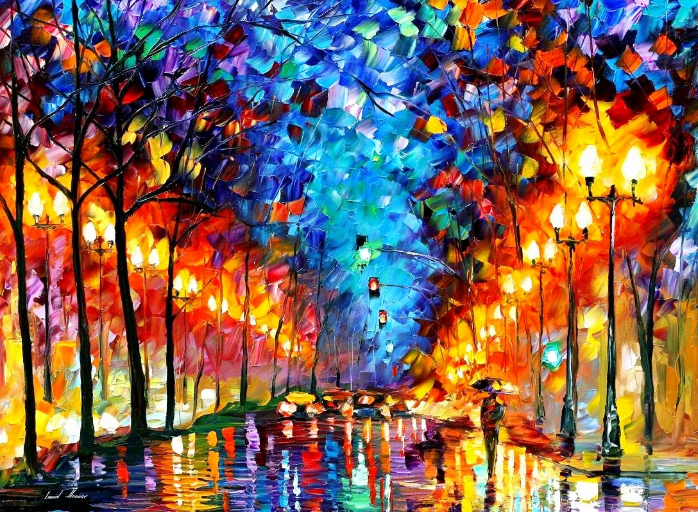

In [11]:
# the style image is:
style_img.tens2pil()

### setup the transfer target

In [12]:
# compute the target features
target_style_feat = compute_feat(nstn, style_img, style_layers, gramfn)
target_content_feat = compute_feat(nstn, content_img, content_layers)

In [13]:
# init the losses & optimizer

catStyle   = LossManager(style_layers, target_style_feat, GramLoss(), weights = OPT_STYLE_WEIGHTS )
# ^ weights = [ 1e2/n**2 for n in [64,128,256,512,512] ]
# v scale = 1e0
catContent = LossManager(content_layers, target_content_feat, torch.nn.MSELoss(), scale = OPT_CONTENT_WEIGHT )  #reduction='sum'

if OPT == 'LBFGS':
    optimizer = torch.optim.LBFGS([generated_img.data], lr=OPT_LR)
elif OPT == 'Adam':
    optimizer = torch.optim.Adam([generated_img.data], lr=OPT_LR)
else:
    raise Exception('unknown optimizer')

transfer = deepstyle.tools.train.TrainMethod(optimizer = optimizer, logger_period = LOGGER_PERIOD)



def closure() -> torch.Tensor:
    """Function that performs training"""
    global transfer

    transfer.optimizer.zero_grad()
    
    feats = nstn( generated_img.data )

    loss_style = catStyle.compute_loss_from_dict( feats )
    loss_cont = catContent.compute_loss_from_dict( feats )
    loss = loss_style + loss_cont

    loss.backward()

    transfer.logger_update( msg = "loss = {}".format( loss.item() ) )
    transfer.iter_count += 1
    return loss

transfer.set_closure( closure )


## transfer

In [14]:
transfer.loop(iter_max = TRANSFER_STEPS, desc = 'Neural Style Transfer')

Neural Style Transfer: 420it [00:30, 12.65it/s, loss = 759477.0625]                         

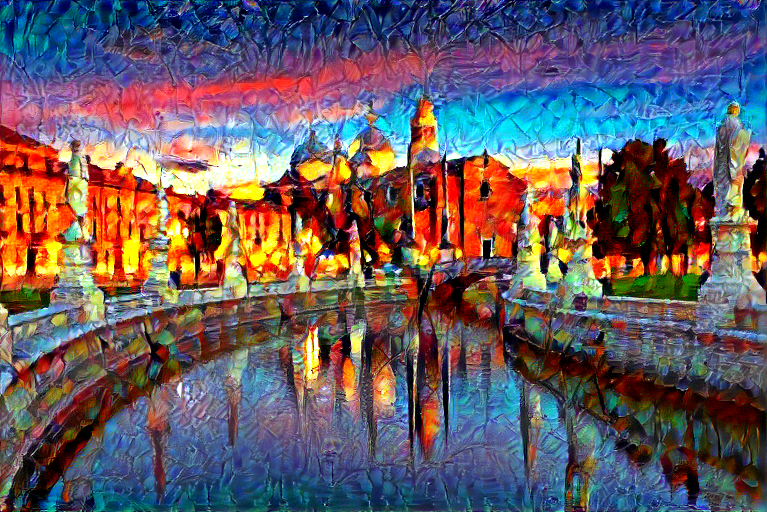

In [15]:
res = cc.postprocess( generated_img )
res

## higher-resolution

In [16]:
if HIGH_RES > IMAGE_SIZE:
    # basically, I will run again the same algo ...

    # ... using higher-resolution style & content
    style_img.size = HIGH_RES
    content_img.size = HIGH_RES

    cc = deepstyle.image.color_control(COLOR_CONTROL, [style_img], [content_img])
    cc.preprocess(force_target = False)

    # ... and initializing the algo from the generated output at lower resolution
    generated_img.resize( content_img.data.shape[2:] )
    generated_img.data.requires_grad = True


    # from now on it is the same as before
    target_style_feat = compute_feat(nstn, style_img, style_layers, gramfn)
    target_content_feat = compute_feat(nstn, content_img, content_layers)

    catStyle   = LossManager(style_layers, target_style_feat, GramLoss(), 
                             weights = OPT_STYLE_WEIGHTS )

    catContent = LossManager(content_layers, target_content_feat, torch.nn.MSELoss(), 
                             scale = OPT_CONTENT_WEIGHT_HR )

    if OPT == 'LBFGS':
        optimizer = torch.optim.LBFGS([generated_img.data], lr=OPT_LR)
    elif OPT == 'Adam':
        optimizer = torch.optim.Adam([generated_img.data], lr=OPT_LR)
    # no Exception here if OPT is not valid

    transfer = deepstyle.tools.train.TrainMethod(optimizer = optimizer, logger_period = LOGGER_PERIOD)


    def closure() -> torch.Tensor:
        """Function that performs training"""
        global transfer

        transfer.optimizer.zero_grad()
        
        feats = nstn( generated_img.data )

        loss_style = catStyle.compute_loss_from_dict( feats )
        loss_cont = catContent.compute_loss_from_dict( feats )
        loss = loss_style + loss_cont

        loss.backward()

        transfer.logger_update( msg = "loss = {}".format( loss.item() ) )
        transfer.iter_count += 1
        return loss


    transfer.set_closure( closure )


Neural Style Transfer: 420it [00:32, 12.92it/s, loss = 759477.0625]


### transfer

In [17]:
if HIGH_RES > IMAGE_SIZE:
    transfer.loop(iter_max = TRANSFER_STEPS_HR, desc = 'high-res Style Transfer')

high-res Style Transfer: 120it [00:13,  7.61it/s, loss = 571765.8125]                         

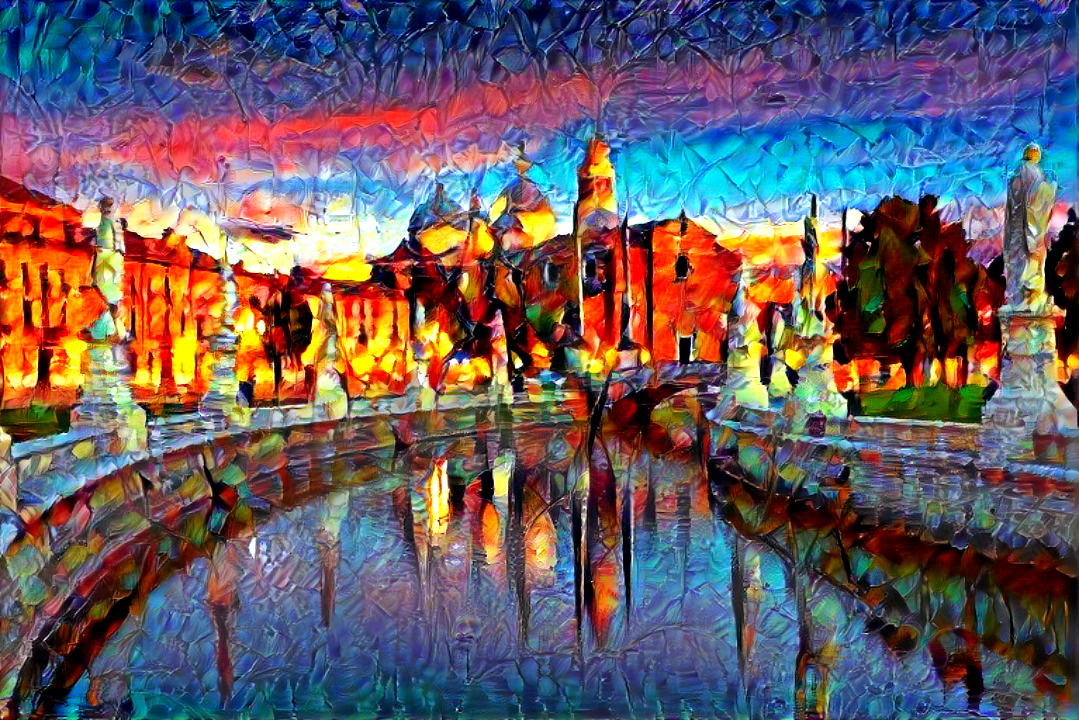

In [18]:
if HIGH_RES > IMAGE_SIZE:
    res = cc.postprocess( generated_img )
res

## save the output

In [19]:
if OUTPUT_IMAGE is not None:
    # remark: this is a PIL image, so you can save it the usual way
    cc.postprocess( generated_img ).save( OUTPUT_IMAGE )